# Notebook walkthrough of the Automated Graph Representation Algorithm for more efficient and accurate Graph Neural Network Performance

Scientific Relevance:

This notebook provides an automated graph conversion method for graph neural networks (GNNs). Our approach uses less computational power and yields similar or superior results to the Open Catalyst Projects graphing approach on sample databases of alloys. The key to this improvement is the targetted edge generation, node embedding and evironment extraction our framework performs that the OCP AtomsToGraphs() function does not provides. for specific details on the algorithms design choices and case studies, please refer to my paper (https://pubs.aip.org/aip/aml/article/1/3/036103/2900763/Automatic-graph-representation-algorithm-for) (open access)

In [1]:
#Standard Library Packages Imports
import json
import multiprocessing as mp
import os
import random
import glob
import copy
import math
from os.path import abspath, dirname, exists, join
import os.path as osp
import sys
sys.path.append("./")
from pathlib import Path
import itertools
import pickle
import shutil
from datetime import datetime
import time #depending on python version, comment this out


#Non-standard Package Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from ase import Atoms, Atom
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.visualize.plot import plot_atoms
from ase.constraints import dict2constraint
from ase.calculators.singlepoint import SinglePointCalculator
from ase.db import connect
from ase.neighborlist import NeighborList, natural_cutoffs
from ase.io import extxyz

import networkx as nx
import mendeleev

import torch
from torch_geometric.loader import DataLoader
from scipy.spatial import distance_matrix

#Import AGRA helper functions
import AGRA_algorithms

#Import GNN Architectures
import GNN_architectures

/Users/zach/opt/anaconda3/envs/pygeometric/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Code Architecture Note: </strong>
</div>
This notebook employs 3 supplementary files for the main classes and functions used.

<strong>AGRA_algorithms.py </strong> - contains our (AGRAs) ASE_To_Graph class, the open catalyst project (OCP) Atom_To_Graph class (solely for comparison), and extra function to handle imported database and data operations.

<strong>GNN_architectures.py</strong> - contain GNNs architectures and a model handler class for easy operation of the models.

<strong>help_functions.py</strong> - basic data transformation functions to clean up the code in GNN_architectures.

We chose to modularize the code this way so that researchers and programmers do not need to search a 1500+ line .py file for specifics.

In short, this notebook will highlight basic functionality of the classes and how to apply them to GNNs and your own datasets/databases. 

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Why do we care about GNNs for material discovery? </strong>
</div>

Depending on how you define different classes of ML models, material discovery generally uses 3 types of models:

<br>

<div style="text-align: left; font-size: 14px; color: #de1d50 ;">
    <strong> Descriptor based models: </strong>such as neural nets,decision trees and random forests
</div>

<div style="text-align: left; font-size: 14px; color: #0ea150 ;">
    <strong> Bayesian models: </strong>such as gaussian process regressors
</div>

<div style="text-align: left; font-size: 14px; color: #1310c9 ;">
    <strong> Graph based models: </strong>such as graph neural nets
</div>
<br>
the key benefit in using graph based models over the other 2 models comes from the inherent descriptor representation they use. Instead of training on datasets composed of arrays of numbers, graph based models train on graphs which contain information in the form of nodes and edges that connect the nodes. In practice,  <strong> this representation allows for better information encapsulation resulting in better accuracies </strong>. This representation also lends itself very well to molecules since we traditionally view molecules as atoms (nodes) and bonds (edges):

<p align="center" width="10%">
    <img width="90%" src="images/convert.png"> 
</p>

<strong>Another key benefit of graphs is the ability to completely automate the conversion of crystallographic information</strong> into GNNs readable formats. A common method to share data amongst researchers is through ASE dbs which possess 5 possible back-ends:
<br> 
1- JSON
<br> 
2- SQLite3
<br> 
3- PostgreSQL
<br> 
4- MySQL
<br> 
5- MariaDB
<br> 
These databases not only possess all the information possibly yielded from a simulation/calculation, but also allow researchers to perform their own feature engineering with the raw data. 
<br> 
While some researchers enjoy the low-level functionality, other researchers simply want to model, optimize and study systems through ML. Our framework offers both capabilities by directly interfacing with ASE dbs (similar the OCP ASE functionality)
<br>
<br>
<div style="text-align: left; font-size: 14px; color: #224CA0 ;">
        <strong>Let us take a look at how our Automated Graph Representation Algorithm (AGRA) can be used to harness these key benefits to accelerate material discovery!</strong>
</div>

# Step 1: Initialize AGRAs ASE_TO_Graph class and generate graphs

>**Class: ASE_To_Graph** must load with pathway for the ASE db and desired feature embedding

>**Function 1.1: import_db** no inputs. outputs are ase_db (ASE db object)

>**Function 1.2: sample_visual** no inputs. provides a sample visual of AGRAs algorithm at work

>**Function 1.3: get_data_from_ase_db** extract graph dataset from an ASE db. Inputs are db (ASE db), adsorbate (str), emb (str). 

>**Function 1.4: split_data** split data into test/val/train sets and save to pickles. inputs are split (float)


In the follow cell, we see a sample visual of a CO2RR extracted db and the resulting OCP and AGRA graphs the respective graphing algorithms result in. 

/Users/zach/Desktop/github_project/AGRA/AGRA_algorithms.py:515: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)


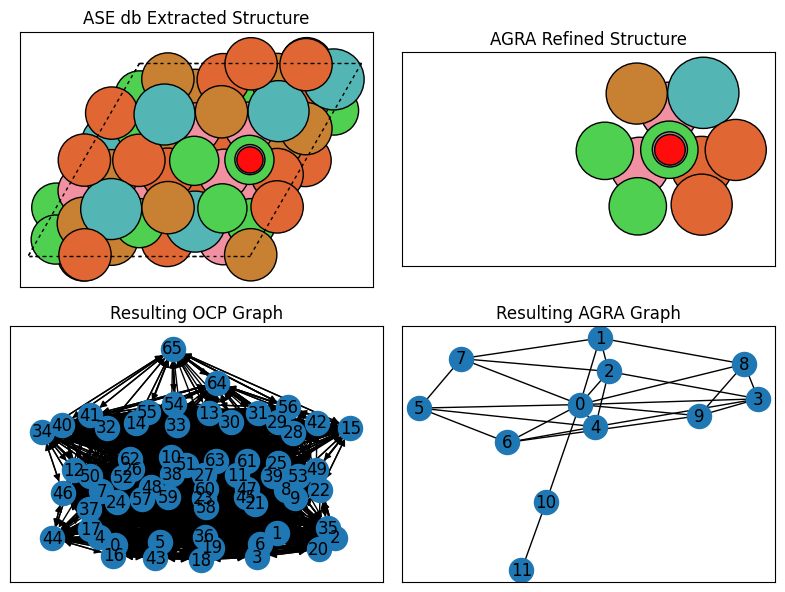

In [2]:
#Intialize ASE_To_Graph Class for AGRA conversion and import the ASE database
A2G = AGRA_algorithms.ASE_To_Graph('full.db','cgcnn92')
ase_db = A2G.import_db()

#(optional) Visualize the a sample structure and graph generation process of AGRA vs. Open Catalyst Project (OCP)
A2G.sample_visual()

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> AGRA vs. OCP Observations: </strong>
</div>

<strong>Considerably less nodes for AGRA </strong> - Since AGRA extracts only the first shell on neighbors based on voronoi faces and radius, the graphs are simplified to a much greater extent. This reduces computation cost associated with model training by multitudes. 

<strong>Edge generation more intention for AGRA</strong> - As seen in the OCPs approach, the edges are generated based on a proximity cutoff which results in both adsorbate atoms (C+O) sharing edges with a large number of surface atoms. While this doesn't hurt accuracy, it does not contribute significant information since the binding site is the most important influences on adsorption. That is why AGRAs edge generation on has the binding site connected to the atom of the adsorbate it is electronically bonded to (connection 0 to 10). The neighboring atoms contribute electron cloud hydridization and and stabilization which is why the binding atoms is then connected to all neighbors. This representation is a bit more intentional.

<strong>Node embedding</strong> - As seen below, AGRA also classifies atoms/nodes into adsorbate, binding site or slab as opposed to OCP which follows adosrbate/slab classification. 

The figure below also summarizes these key differences

<p align="center" width="10%">
    <img width="90%" src="images/diff.png"> 
</p>

In [6]:
#Generate a pickle file of the ASE db specifying only adsorbate of interest and split dataset
#Do not run this line of code since it will take some time depending on hardware


#A2G.get_data_from_asedb(ase_db,  adsorbate='CO', emb="cgcnn92")
#A2G.split_data(split=0.1)

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong>Data Efficiency Remark: </strong>
</div>

When saving the graph datasets of the sample databases, <strong>AGRAs graph representation required 1/9 the memory of the OCPs graphs </strong>. For a random extracted 1000 datapoints from the databases used in our paper, the following pickle file sizes were extracted:
<br>


| OCP Memory Used | AGRA Memory Used | 
|:---------------:|:---------------:|
| 410 MB  | 45 MB   | 
| 410 kB/datapoint   | 45 kB/datapoint   | 
 
<div style="text-align: center; font-size: 16px; color: #12277a ;">
    <strong>~9 more memory efficient! </strong>
</div>


# Step 2: Select your baseline GNN architecture and initialize Model_Handler class with it
>**Class: Model_Handler** must initialize with a configuration and file name. Inputs are config (dictionnary), campaign name (str)

>**GNN a) NNConv** - Simple baseline

>**GNN b) CGCNN** - Popular GNN based on Xie's work in the Grossman Group 

>**Function 2.1: main** train, evaluate and save best model. inputs are training file name (str). outputs torch geometric model, test dataset (list)

>**Function 2.2: get_train_history** extract the training history, plot it and save to a csv. no inputs. outputs are train_history (pandas df)

>**Function 2.3: get_train_history** evaluate the best models performance. inputs are test dataset (list), testfile (str). Other inputs optional. outputs are err (float), df (pandas df).
2 sample GNN architectures are described below. See the GNN_architectures.py file for exact code and class information

>**Function 2.4: plot_train** plot training. Inputs are df from Function 2.3 (pandas df). No outputs.

<p align="center" width="10%">
    <img width="90%" src="images/gnns.png"> 
</p>

Importing CGCNN Configuration
Folder [CO_Train_cgcnn92] is already there
train_sampler len: 111
val_sampler len: 12
Epoch: 0000, LR: 0.000100, Loss: 1.0026373, Val MAE: 0.1116698
Epoch: 0050, LR: 0.000034, Loss: 0.0618372, Val MAE: 0.0904069
Epoch: 0100, LR: 0.000010, Loss: 0.0644350, Val MAE: 0.0860839
Epoch: 0150, LR: 0.000010, Loss: 0.0423177, Val MAE: 0.0823382
Epoch: 0200, LR: 0.000010, Loss: 0.0231044, Val MAE: 0.0818955
Epoch: 0250, LR: 0.000010, Loss: 0.0538556, Val MAE: 0.0793095
Epoch: 0300, LR: 0.000010, Loss: 0.0412081, Val MAE: 0.0781982
Epoch: 0350, LR: 0.000010, Loss: 0.0181112, Val MAE: 0.0752489
Epoch: 0400, LR: 0.000010, Loss: 0.0237196, Val MAE: 0.0795797
Epoch: 0450, LR: 0.000010, Loss: 0.0225167, Val MAE: 0.0793445
Epoch: 0500, LR: 0.000010, Loss: 0.0189967, Val MAE: 0.0787249
Epoch: 0550, LR: 0.000010, Loss: 0.0292153, Val MAE: 0.0779319
Epoch: 0600, LR: 0.000010, Loss: 0.0158392, Val MAE: 0.0789411
Epoch: 0650, LR: 0.000010, Loss: 0.0537055, Val MAE: 0.0778172
Ep

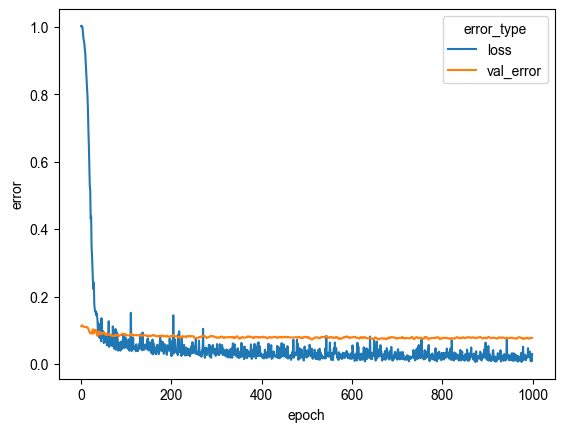

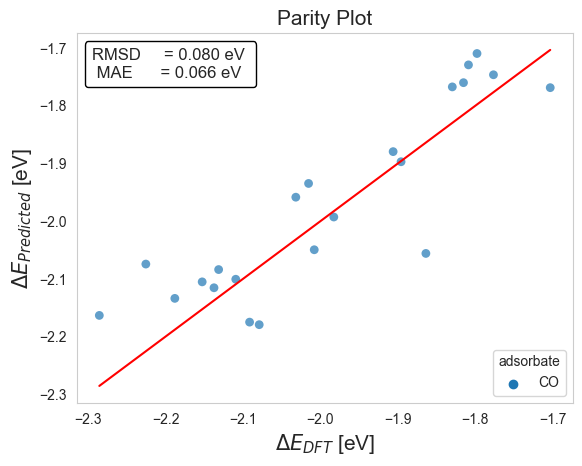

In [3]:
#Specify model you want to use
model='cgcnn'
#model='nnconv'

#Specify Sample training/test sets in pickle format extracted from Step 1.
trainfile = 'sample_dataset/CO_Train_cgcnn92.pickle'
testfile = 'sample_dataset/CO_Test_cgcnn92.pickle'
campaign_name = Path(Path(trainfile).stem).stem

#Sample config files of 2 GNNs. 
#We purposefully list out the parameters for readability and understanding.
if model=='cgcnn': #Model fro Xie et. al. (https://arxiv.org/abs/1710.10324)
    config = {'lr': 0.0001 ,
              'aggr': 'add',
              'batch_size':32,
              'Nepoch': 1000,
              'atom_embedding_size':64,
              'num_graph_conv_layers':6,
              'num_fc_layers':4,
              'fc_feat_size':128,
              'batch_norm':True,
              'bias':True,
              'momentum': 0.9,
              'weight_decay':5e-4,
              'emb':'cgcnn92', # or megnet16
              'model':'cgcnn'}
    
if model=='nnconv': #baseline model
    config = {'lr': 0.0001 ,
              'aggr': 'mean',
              'node_embedding_dim': 64,
              'edge_embedding_dim': 128,
              'batch_size':8,
              'Nepoch': 1000,
              'processing_steps':3,
              'num_layers':1,
              'num_iter':5,
              'emb':'cgcnn92', # or megnet16
              'model':'nnconv'}

#Initialize the Model_Handler Class which implements all basic GNN functions
Handler = GNN_architectures.Model_Handler(config,campaign_name)

#Peform main training loop and save the best model and dataset 
best_model, test_dataset = Handler.main(trainfile, 
                                data_size=None)
#(optional) Extract the training history
train_history = Handler.get_train_history()
#Evaluate the best model and visualize
err, df= Handler.test_best_model(test_dataset, 
                         testfile =testfile,  
                         checkpoint_dir=None, 
                         best_model=best_model, 
                         batch_size=8, 
                         device="cpu",
                         save_df=True)

#(Optional) plot training history
Handler.plot_train(df)

# Final remarks and key benefits offered:
<br>
<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Improved Accuracy and Storage: </strong>
</div>

<strong> Even with the reduced computational cost, </strong> AGRA still yielded similar or superior results to the OCPs graph representation approach on the combined datasets listed below. For more information on the individual material systems and datasets, please refer to our paper.

<p align="center" width="10%">
    <img width="60%" src="images/acc.png"> 
</p>

<div style="text-align: left; font-size: 16px; color: #224CA0 ;">
    <strong> Potential to Push Boundaries: </strong>
</div>

as pictured below, it is common to performance composition optimization or elemental combination intrapolation. What has not been done before is predicting new chemical reactions on substrates without prior training data on the adsorbate/substrate combination. If we can succesfully achieve this, the framework would be able to harness previously published databases to discover new applications, sometimes better than their originally intended application. 

The concept of taking a system designed for reaction 1 and applying it to reaction 2 was proven tio yield best in field catalytic performance in one of my previous works (https://github.com/gariepyz/NN-Decomposition-For-Empirically-Derived-Insight)


<p align="center" width="10%">
    <img width="50%" src="images/preds.png"> 
</p>

<br>
Although the accuracy of this theorized extrapolation lies outside the std of the MAE of the test set, this framework still shows a lot of promise for accelerating the discovery of bounary pushing technologies.
<br>

<p align="center" width="10%">
    <img width="60%" src="images/results.png"> 
</p>